### Import Necessary Libraries

In [86]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
import data_setup, engine, set_seeds, utils, predict
from engine import train_step, test_step
from typing import Dict, List, Tuple
from tqdm.auto import tqdm
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
# from predict import pred_and_plot_image
from PIL import Image

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
device

'cuda'

### Get our Dataset

In [6]:
image_path = Path("data/pizza_steak_sushi")

In [10]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x1a3087f0b50>,
 ['pizza', 'steak', 'sushi'])

### Loading The Model


In [8]:
weights_path = Path('models/EfficientNet-b0.pth')

In [9]:
model = torchvision.models.efficientnet_b0(weights=weights_path).to(device)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [11]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

# Since we're creating a new layer with random weights (torch.nn.Linear),
# let's set the seeds
set_seeds.set_seeds()

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True).to(device))

In [12]:
# # Get a summary of the model (uncomment for full output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [13]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training the Model with Tensorboard

In [14]:
writer = SummaryWriter()

In [15]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
          
          """Trains and tests a PyTorch model.

          Passes a target PyTorch models through train_step() and test_step()
          functions for a number of epochs, training and testing the model
          in the same epoch loop.

          Calculates, prints and stores evaluation metrics throughout.

          Args:
            model: A PyTorch model to be trained and tested.
            train_dataloader: A DataLoader instance for the model to be trained on.
            test_dataloader: A DataLoader instance for the model to be tested on.
            optimizer: A PyTorch optimizer to help minimize the loss function.
            loss_fn: A PyTorch loss function to calculate loss on both datasets.
            epochs: An integer indicating how many epochs to train for.
            device: A target device to compute on (e.g. "cuda" or "cpu").
            
          Returns:
            A dictionary of training and testing loss as well as training and
            testing accuracy metrics. Each metric has a value in a list for 
            each epoch.
            In the form: {train_loss: [...],
                      train_acc: [...],
                      test_loss: [...],
                      test_acc: [...]} 
            For example if training for epochs=2: 
                    {train_loss: [2.0616, 1.0537],
                      train_acc: [0.3945, 0.3945],
                      test_loss: [1.2641, 1.5706],
                      test_acc: [0.3400, 0.2973]} 
          """
          # Create empty results dictionary
          results = {"train_loss": [],
                    "train_acc": [],
                    "test_loss": [],
                    "test_acc": []
          }

          # Loop through training and testing steps for a number of epochs
          for epoch in tqdm(range(epochs)):
            train_loss, train_acc = train_step(model=model,
                                              dataloader=train_dataloader,
                                              loss_fn=loss_fn,
                                              optimizer=optimizer,
                                              device=device)
            test_loss, test_acc = test_step(model=model,
                                            dataloader=test_dataloader,
                                            loss_fn=loss_fn,
                                            device=device)

            # Print out what's happening
            print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
            )

            # Update results dictionary
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)

            ### New: Experiment tracking ###
            # Add loss results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                              tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                              global_step=epoch)

            # Add accuracy results to SummaryWriter
            writer.add_scalars(main_tag="Accuracy", 
                              tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                              global_step=epoch)
            
            # Track the PyTorch model architecture
            writer.add_graph(model=model, 
                            # Pass in an example input
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))
          
          # Close the writer
          writer.close()
          
          ### End new ###

          # Return the filled results at the end of the epochs
          return results

In [16]:
set_seeds.set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0946 | train_acc: 0.4570 | test_loss: 0.9196 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.9089 | train_acc: 0.6523 | test_loss: 0.8054 | test_acc: 0.7945
Epoch: 3 | train_loss: 0.7970 | train_acc: 0.7383 | test_loss: 0.6795 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.6902 | train_acc: 0.8438 | test_loss: 0.6662 | test_acc: 0.8352
Epoch: 5 | train_loss: 0.7209 | train_acc: 0.7070 | test_loss: 0.6594 | test_acc: 0.8049


In [17]:
results

{'train_loss': [1.0946287959814072,
  0.9088862761855125,
  0.7970260381698608,
  0.6902002766728401,
  0.7208762876689434],
 'train_acc': [0.45703125, 0.65234375, 0.73828125, 0.84375, 0.70703125],
 'test_loss': [0.9196480909983317,
  0.8054017424583435,
  0.679539680480957,
  0.6662053267161051,
  0.6593731244405111],
 'test_acc': [0.5085227272727273,
  0.7945075757575758,
  0.9071969696969697,
  0.8352272727272728,
  0.8049242424242425]}

In [57]:
%load_ext tensorboard
%tensorboard --logdir runs --host localhost --port=6005

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
%reload_ext tensorboard

In [38]:
!kill 9572

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    # returns current date in YYYY-MM-DD format
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        # Create log directory path
        log_dir = os.path.join(
            "runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [19]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs\2024-09-14\data_10_percent\effnetb0\5_epochs...


### Adding Writer function to our Train Function

In [20]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          # new parameter to take in a writer
          writer: torch.utils.tensorboard.writer.SummaryWriter
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [21]:
# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],  # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])  # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 1. Resize the images
    transforms.ToTensor(),  # 2. Turn the images into tensors with values between 0 & 1
    normalize  # 3. Normalize the images so their distributions match the ImageNet dataset
])

In [23]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [28]:
train_dir_10_percent = image_path / "train"
dir_20_percent = Path('data/pizza_steak_sushi_20_percent')
train_dir_20_percent =  dir_20_percent /"train"

test_dir = dir_20_percent / "test"

In [29]:
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi_20_percent\test


In [30]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE
                                                                                          )

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE
                                                                                          )

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(
    f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(
    f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(
    f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 5 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### EfficientNet B2

In [31]:
# "DEFAULT" means best available weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

print(
    f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\User/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:09<00:00, 4.02MB/s]


Number of in_features to final layer of EfficientNetB2: 1408


In [33]:
utils.save_model(model=effnetb2, model_name='effnetb2.pth', target_dir='models')

[INFO] Saving model to: models\effnetb2.pth


In [39]:
OUT_FEATURES = len(class_names)

In [40]:
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device

    # 2. Freeze the base model layers
    for param in effnetb2.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds.set_seeds()

    # 4. Change the classifier head
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    effnetb2.name = "effnetb2"
    print(f"[INFO] Created new {effnetb2.name} model.")
    return effnetb2

In [45]:
effnetb0 = model

In [41]:
effnetb2 = create_effnetb2()

[INFO] Created new effnetb2 model.


In [42]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Training with BOth Eff Net b0 and b2

In [43]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [46]:
%%time

set_seeds.set_seeds(seed=42)

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = effnetb0 # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = effnetb2 # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            utils.save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs\2024-09-14\data_10_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5674 | train_acc: 0.9062 | test_loss: 0.5190 | test_acc: 0.8756
Epoch: 2 | train_loss: 0.5216 | train_acc: 0.9336 | test_loss: 0.4931 | test_acc: 0.8881
Epoch: 3 | train_loss: 0.5002 | train_acc: 0.8828 | test_loss: 0.4717 | test_acc: 0.8915
Epoch: 4 | train_loss: 0.5128 | train_acc: 0.8086 | test_loss: 0.4551 | test_acc: 0.8852
Epoch: 5 | train_loss: 0.4416 | train_acc: 0.8281 | test_loss: 0.4256 | test_acc: 0.8977
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-09-14\data_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9343 | test_acc: 0.7182
Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8400 | test_acc: 0.7937
Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7426 | test_acc: 0.8784
Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7066 | test_acc: 0.8818
Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.6810 | test_acc: 0.8483
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, saving to: runs\2024-09-14\data_10_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4073 | train_acc: 0.9102 | test_loss: 0.3838 | test_acc: 0.9040
Epoch: 2 | train_loss: 0.4133 | train_acc: 0.8359 | test_loss: 0.3716 | test_acc: 0.9040
Epoch: 3 | train_loss: 0.4143 | train_acc: 0.8203 | test_loss: 0.3727 | test_acc: 0.8886
Epoch: 4 | train_loss: 0.3827 | train_acc: 0.8164 | test_loss: 0.3841 | test_acc: 0.8795
Epoch: 5 | train_loss: 0.3586 | train_acc: 0.9414 | test_loss: 0.3763 | test_acc: 0.8636
Epoch: 6 | train_loss: 0.4475 | train_acc: 0.8438 | test_loss: 0.3568 | test_acc: 0.9040
Epoch: 7 | train_loss: 0.3606 | train_acc: 0.8516 | test_loss: 0.3227 | test_acc: 0.9193
Epoch: 8 | train_loss: 0.3862 | train_acc: 0.8359 | test_loss: 0.3198 | test_acc: 0.9040
Epoch: 9 | train_loss: 0.3249 | train_acc: 0.8359 | test_loss: 0.2946 | test_acc: 0.9165
Epoch: 10 | train_loss: 0.3926 | train_acc: 0.8320 | test_loss: 0.3125 | test_acc: 0.9102
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9286 | test_acc: 0.7176
Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8699 | test_acc: 0.7869
Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7693 | test_acc: 0.8472
Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7204 | test_acc: 0.8568
Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.6864 | test_acc: 0.8420
Epoch: 6 | train_loss: 0.6111 | train_acc: 0.7812 | test_loss: 0.6345 | test_acc: 0.8756
Epoch: 7 | train_loss: 0.6126 | train_acc: 0.8008 | test_loss: 0.5815 | test_acc: 0.8727
Epoch: 8 | train_loss: 0.5202 | train_acc: 0.9336 | test_loss: 0.5641 | test_acc: 0.8858
Epoch: 9 | train_loss: 0.5426 | train_acc: 0.8008 | test_loss: 0.5610 | test_acc: 0.8642
Epoch: 10 | train_loss: 0.4909 | train_acc: 0.8125 | test_loss: 0.5717 | test_acc: 0.8273
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3427 | train_acc: 0.8979 | test_loss: 0.2714 | test_acc: 0.9102
Epoch: 2 | train_loss: 0.3435 | train_acc: 0.8771 | test_loss: 0.2581 | test_acc: 0.9165
Epoch: 3 | train_loss: 0.3330 | train_acc: 0.8708 | test_loss: 0.2485 | test_acc: 0.9102
Epoch: 4 | train_loss: 0.2799 | train_acc: 0.9229 | test_loss: 0.2473 | test_acc: 0.9227
Epoch: 5 | train_loss: 0.2805 | train_acc: 0.8979 | test_loss: 0.2395 | test_acc: 0.9074
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-09-14\data_20_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5521 | test_loss: 0.7845 | test_acc: 0.8477
Epoch: 2 | train_loss: 0.7299 | train_acc: 0.7604 | test_loss: 0.6399 | test_acc: 0.8943
Epoch: 3 | train_loss: 0.6023 | train_acc: 0.8458 | test_loss: 0.5539 | test_acc: 0.9034
Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5104 | test_acc: 0.8727
Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4391 | test_acc: 0.9097
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, saving to: runs\2024-09-14\data_20_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2459 | train_acc: 0.9229 | test_loss: 0.2276 | test_acc: 0.9227
Epoch: 2 | train_loss: 0.2415 | train_acc: 0.9313 | test_loss: 0.2216 | test_acc: 0.9290
Epoch: 3 | train_loss: 0.2533 | train_acc: 0.9250 | test_loss: 0.2288 | test_acc: 0.9102
Epoch: 4 | train_loss: 0.2109 | train_acc: 0.9104 | test_loss: 0.2120 | test_acc: 0.9352
Epoch: 5 | train_loss: 0.2558 | train_acc: 0.9146 | test_loss: 0.1960 | test_acc: 0.9415
Epoch: 6 | train_loss: 0.1780 | train_acc: 0.9625 | test_loss: 0.2063 | test_acc: 0.9290
Epoch: 7 | train_loss: 0.2268 | train_acc: 0.9208 | test_loss: 0.2121 | test_acc: 0.9165
Epoch: 8 | train_loss: 0.2081 | train_acc: 0.9479 | test_loss: 0.2085 | test_acc: 0.9165
Epoch: 9 | train_loss: 0.1700 | train_acc: 0.9833 | test_loss: 0.2169 | test_acc: 0.9102
Epoch: 10 | train_loss: 0.1824 | train_acc: 0.9625 | test_loss: 0.2012 | test_acc: 0.9352
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5521 | test_loss: 0.7773 | test_acc: 0.8477
Epoch: 2 | train_loss: 0.7299 | train_acc: 0.7604 | test_loss: 0.6376 | test_acc: 0.8943
Epoch: 3 | train_loss: 0.6023 | train_acc: 0.8458 | test_loss: 0.5535 | test_acc: 0.9034
Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5103 | test_acc: 0.8727
Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4390 | test_acc: 0.9097
Epoch: 6 | train_loss: 0.3889 | train_acc: 0.9104 | test_loss: 0.4189 | test_acc: 0.8915
Epoch: 7 | train_loss: 0.3483 | train_acc: 0.9271 | test_loss: 0.3926 | test_acc: 0.9159
Epoch: 8 | train_loss: 0.3862 | train_acc: 0.8771 | test_loss: 0.3843 | test_acc: 0.9034
Epoch: 9 | train_loss: 0.3309 | train_acc: 0.8979 | test_loss: 0.3777 | test_acc: 0.8790
Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8896 | test_loss: 0.3406 | test_acc: 0.9034
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

### Loading Our Best Performing Model

In [63]:
best_model_path = Path("models/07_effnetb0_data_20_percent_10_epochs.pth")

best_model = torchvision.models.efficientnet_b0(weights=best_model_path)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
best_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {best_model_size} MB")

EfficientNetB2 feature extractor model size: 15 MB


### Predicting WIth our Best Performing Model

IndexError: list index out of range

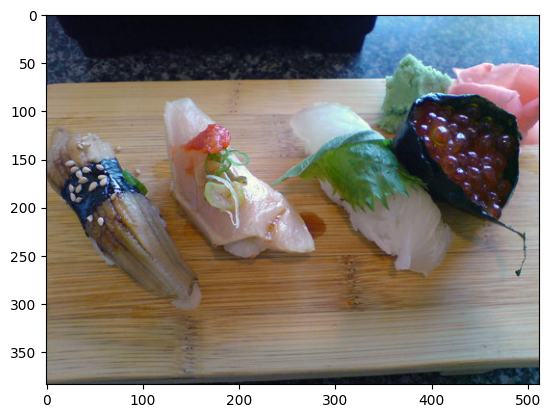

In [87]:
import random
num_images_to_plot = 3
# get all test image paths from 20% dataset
test_image_path_list = list(
    Path(dir_20_percent / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)  # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

In [68]:
test_image_path_list = list(
    Path(dir_20_percent / "test").glob("*/*.jpg"))

In [69]:
test_image_path_list

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/148765.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_pe

In [70]:
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

In [71]:
test_image_path_sample

[WindowsPath('data/pizza_steak_sushi_20_percent/test/steak/3063435.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/steak/2756200.jpg')]

In [74]:
test_image_path_sample[0]

WindowsPath('data/pizza_steak_sushi_20_percent/test/steak/2307638.jpg')

In [77]:
img = Image.open(test_image_path_sample[0])

In [78]:
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [79]:
best_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

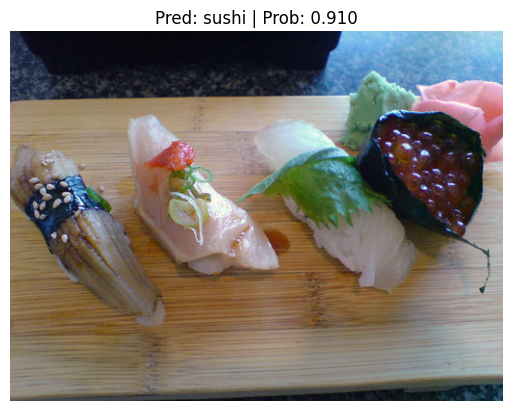

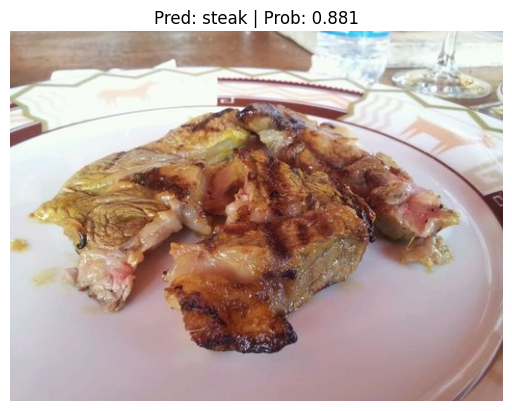

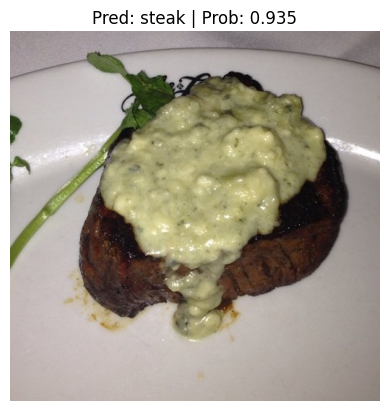

In [88]:
for img_path in test_image_path_sample:
    img = Image.open(img_path)
    model.eval()
    with torch.inference_mode():
        transformed_image = manual_transforms(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)